# Enriching Grants part 3: adding related Patents and Clinical Trials data

In this third and final final part of the grants enrichment tutorial we are going to extract from Dimensions all Patents and Clinical Trials information linked to our *vaccines* grants datasets.  

This tutorial builds on the previous one, *Enriching Grants with Publications Information from Dimensions*, and it assumes that our grants list already includes Dimensions IDs as well as publications counts for each grant. 

The enriched grants list we are starting from can be [downloaded here](http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-2.csv)

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [2]:
!pip install dimcli tqdm plotly -U --quiet 

import dimcli
from dimcli.shortcuts import *
import sys, time, json
import pandas as pd
from tqdm.notebook import tqdm as progressbar

import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')    
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.5)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


## Reusing the enriched grants data from part-2

First, we are going to load the enriched grants dataset resulted from part-2 of this tutorial: ["vaccines-grants-sample-part-2.csv"](http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-2.csv). 


In [4]:
grants = pd.read_csv("http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-2.csv")
# pull out the grant IDs as a list
grantsids = list(grants['Dimensions ID']) 

This file contains ~1k recent grants records on the topic of vaccines. Now we can preview the contents of the file.

In [84]:
grants.head(10)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID,Resulting Publications
0,30410203277,疫苗－整体方案,1208.0,2004,2004,National Natural Science Foundation of China,China,grant.8172033,0
1,620792,Engineering Inhalable Vaccines,26956.0,2017,2018,Natural Sciences and Engineering Research Council,Canada,grant.7715379,0
2,599115,Engineering Inhalable Vaccines,26403.0,2016,2017,Natural Sciences and Engineering Research Council,Canada,grant.6962629,0
3,251564,HIV Vaccine research,442366.0,2003,2007,National Health and Medical Research Council,Australia,grant.6723913,0
4,334174,HIV Vaccine Development,236067.0,2005,2009,National Health and Medical Research Council,Australia,grant.6722306,1
5,910292,Dengue virus vaccine.,130890.0,1991,1993,National Health and Medical Research Council,Australia,grant.6716312,0
6,578221,Engineering Inhalable Vaccines,27386.0,2015,2016,Natural Sciences and Engineering Research Council,Canada,grant.5526688,0
7,IC18980360,Schistosomiasis Vaccine Network.,0.0,1998,2000,European Commission,Belgium,grant.3733803,0
8,7621798,Pneumococcal Ribosomal Vaccines,46000.0,1977,1980,Directorate for Biological Sciences,United States,grant.3274273,0
9,255890,Rational vaccine design,7138.0,2003,2004,Natural Sciences and Engineering Research Council,Canada,grant.2936015,0


## Extracting linked Patents data

Using a similar methodology as with publications, we can easily extract all patents linked to each grant in two steps. 

* retrieve all the relevant patents records using the `associated_grant_ids` field (see also the [data model](https://docs.dimensions.ai/dsl/data-sources.html) and the  [patents API fields](https://docs.dimensions.ai/dsl/datasource-patents.html))
* group patents by grant ID in so that we can have a single count per record 

Note: in this case we can iterate 400 grants at a time cause in general there are much less associated patents per grant (compared to publications).

In [85]:
#
# the main query
#
q = """search patents 
        where associated_grant_ids in {} 
      return patents[basics+associated_grant_ids]"""


#
# let's loop through all grants IDs in chunks and query Dimensions 
#
print("===\nExtracting patents data ...")
results = []

for chunk in progressbar(list(chunks_of(list(grantsids), 400))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=False)
    results += data.patents
    time.sleep(1)

#
# put the patents data into a dataframe, remove duplicates and save
#
patents = pd.DataFrame().from_dict(results)
print("Patents found: ", len(patents))
patents.drop_duplicates(subset='id', inplace=True)
print("Unique Patents found: ", len(patents))

if 'associated_grant_ids' in patents:
    # turning lists into strings to ensure compatibility with CSV loaded data
    # see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
    patents['associated_grant_ids'] = patents['associated_grant_ids'].apply(lambda x: ','.join(map(str, x))) 
else:
    patents['associated_grant_ids'] = ""


#
# count patents per grant and enrich the original dataset
#
def patents_for_grantid(grantid):
  global patents
  return patents[patents['associated_grant_ids'].str.contains(grantid)]

print("===\nCounting patents per grant...")

l = []
for x in progressbar(grantsids):
  l.append(len(patents_for_grantid(x)))

grants['Associated Patents'] = l

print("===\nDone")

===
Extracting patents data ...



Patents found:  1727
Unique Patents found:  1658
===
Counting patents per grant...



===
Done


Let's quickly preview the patents dataset, and the grants one, which now has an extra column counting patents. 

In [86]:
patents.head(5)

,year,title,associated_grant_ids,id,publication_date,assignees,assignee_names,granted_year,filing_status,inventor_names,times_cited
0,2007,Protein matrix vaccines and methods of making ...,grant.2698981,US-8642042-B2,2014-02-04,"[{'id': 'grid.38142.3c', 'country_name': 'Unit...","[Harvard College, MEKALANOS JOHN J, HARVARD CO...",2014.0,Grant,[John J. Mekalanos],NaN
1,2004,Human cytomegalovirus antigens expressed in MV...,"grant.2473626,grant.2455882,grant.2597511,gran...",US-7163685-B2,2007-01-16,"[{'id': 'grid.410425.6', 'country_name': 'Unit...","[City of Hope National Medical Center, HOPE CITY]",2007.0,Grant,"[Don Jeffrey Diamond, Zhongde Wang]",9.0
2,2015,Haplotying of HLA loci with ultra-deep shotgun...,"grant.2695874,grant.2699213,grant.2410619,gran...",US-9920370-B2,2018-03-20,"[{'id': 'grid.168010.e', 'country_name': 'Unit...","[Leland Stanford Junior University, UNIV LELAN...",2018.0,Grant,"[Chunlin Wang, Michael N. Mindrinos, Mark M. D...",0.0
3,2015,ANTIMICROBIAL AGENTS AND SCREENING METHODS,"grant.2684876,grant.2698981",US-20170173008-A1,2017-06-22,"[{'id': 'grid.38142.3c', 'country_name': 'Unit...","[Harvard College, HARVARD COLLEGE]",NaN,Application,"[Beckwith Roger JONATHAN, Rachel Dutton, Marku...",0.0
4,2015,SOFTWARE HAPLOTYING OF HLA LOCI,"grant.2552606,grant.2692707,grant.2695874,gran...",US-20150379195-A1,2015-12-31,"[{'id': 'grid.168010.e', 'country_name': 'Unit...","[Leland Stanford Junior University, UNIV LELAN...",NaN,Application,"[Chunlin Wang, Michael N. Mindrinos, Mark M. D...",3.0


In [87]:
grants.sort_values("Associated Patents", ascending=False).head(5)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID,Resulting Publications,Associated Patents
435,P30CA008748,Cancer Center Support Grant,250916048.0,1977,2023,National Cancer Institute,United States,grant.2438793,12716,192
431,P30CA021765,Cancer Center Support Grant (CCSG),117691216.0,1977,2024,National Cancer Institute,United States,grant.2438833,2220,120
423,P30CA016672,Cancer Center Support Grant,207129520.0,1978,2024,National Cancer Institute,United States,grant.2438826,11839,97
412,P30CA033572,Cancer Center Support Grant,55374368.0,1981,2022,National Cancer Institute,United States,grant.2438845,975,89
411,P01CA030206,Hematopoietic Cell Transplantation for Hematol...,31844534.0,1981,2013,National Cancer Institute,United States,grant.2435461,92,70


## Extracting linked Clinical Trials data

Now we can repeat the same process once more, for Clinical Trials. The field we need is called  `associated_grant_ids`  (see also the [clinical trials API docs](https://docs.dimensions.ai/dsl/datasource-clinical_trials.html)). 

As with patents, we can iterate 400 grants at a time cause in general there is much less associated content per grant (compared to publications).

In [88]:
#
# the main query
#
q = """search clinical_trials 
        where associated_grant_ids in {} 
      return clinical_trials[basics+associated_grant_ids]"""


#
# let's loop through all grants IDs in chunks and query Dimensions 
#
print("===\nExtracting clinical trials data ...")
results = []

for chunk in progressbar(list(chunks_of(list(grantsids), 400))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=False)
    results += data.clinical_trials
    time.sleep(1)

#
# put the patents data into a dataframe, remove duplicates and save
#
clinical_trials = pd.DataFrame().from_dict(results)
print("Clinical Trials found: ", len(clinical_trials))
clinical_trials.drop_duplicates(subset='id', inplace=True)
print("Unique Clinical Trials found: ", len(clinical_trials))

if 'associated_grant_ids' in clinical_trials:
    # turning lists into strings to ensure compatibility with CSV loaded data
    clinical_trials['associated_grant_ids'] = clinical_trials['associated_grant_ids'].apply(lambda x: ','.join(map(str, x))) 
else:
    clinical_trials['associated_grant_ids'] = ""


#
# count patents per grant and enrich the original dataset
#
def cltrials_for_grantid(grantid):
  global clinical_trials
  return clinical_trials[clinical_trials['associated_grant_ids'].str.contains(grantid)]

print("===\nCounting clinical trials per grant...")
l = []
for x in progressbar(grantsids):
  l.append(len(cltrials_for_grantid(x)))

grants['Associated Clinical Trials'] = l

print("===\nDone")

===
Extracting clinical trials data ...



Clinical Trials found:  5570
Unique Clinical Trials found:  5233
===
Counting clinical trials per grant...



===
Done


In [89]:
clinical_trials.head(5)

,title,associated_grant_ids,active_years,investigator_details,id
0,"Continued, Long-Term Follow-Up and Lenalidomid...",grant.2691735,"[2015, 2016, 2017, 2018, 2019]","[[Mary Horowitz, MD, Study Director, Center fo...",NCT02322320
1,A Pilot Study of Neoadjuvant Cetuximab in Adva...,grant.2438866,"[2015, 2016, 2017, 2018, 2019, 2020]","[[Janice Mehnert, , Principal Investigator, Ru...",NCT02324608
2,A Continuation Clinical Trial of Every Three-W...,grant.2438866,"[2015, 2016, 2017, 2018]","[[Jyoti Malhotra, , Principal Investigator, Ru...",NCT02324621
3,A Phase I and Randomized Phase II Double Blind...,grant.3536099,"[2015, 2016, 2017, 2018, 2019, 2020]","[[Lakshmi Rajdev, , Principal Investigator, EC...",NCT02344810
4,"A Randomized, Multi-Center, Phase III Trial of...",grant.2691735,"[2015, 2016, 2017, 2018, 2019, 2020, 2021]","[[Mary Horowitz, MD, Study Director, Center fo...",NCT02345850


In [90]:
grants.sort_values("Associated Clinical Trials", ascending=False).head(5)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID,Resulting Publications,Associated Patents,Associated Clinical Trials
423,P30CA016672,Cancer Center Support Grant,207129520.0,1978,2024,National Cancer Institute,United States,grant.2438826,11839,97,778
415,P30CA015083,Mayo Comprehensive Cancer Center Grant,110102400.0,1980,2024,National Cancer Institute,United States,grant.2438813,1096,21,362
436,P30CA015704,Cancer Center Support Grant,216676224.0,1977,2024,National Cancer Institute,United States,grant.2438816,1350,21,350
410,U10CA032102,Southwest Oncology Group Treatment Grant,141286976.0,1981,2015,National Cancer Institute,United States,grant.2693350,229,2,264
404,P30CA043703,Case Comprehensive Cancer Center Support Grant,101426208.0,1987,2023,National Cancer Institute,United States,grant.2438851,528,19,231


Let's now save the data and preview it. 

In [91]:
grants.to_csv("vaccines-grants-sample-part-3.csv", index=False)
grants.head(5)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID,Resulting Publications,Associated Patents,Associated Clinical Trials
0,30410203277,疫苗－整体方案,1208.0,2004,2004,National Natural Science Foundation of China,China,grant.8172033,0,0,0
1,620792,Engineering Inhalable Vaccines,26956.0,2017,2018,Natural Sciences and Engineering Research Council,Canada,grant.7715379,0,0,0
2,599115,Engineering Inhalable Vaccines,26403.0,2016,2017,Natural Sciences and Engineering Research Council,Canada,grant.6962629,0,0,0
3,251564,HIV Vaccine research,442366.0,2003,2007,National Health and Medical Research Council,Australia,grant.6723913,0,0,0
4,334174,HIV Vaccine Development,236067.0,2005,2009,National Health and Medical Research Council,Australia,grant.6722306,1,0,0


## Data Exploration

Now we can explore a bit the grants+publications+patents+clinical_trials dataset using the [plotly express](https://plot.ly/python/plotly-express/) library. 


### How many linked objects overall? 


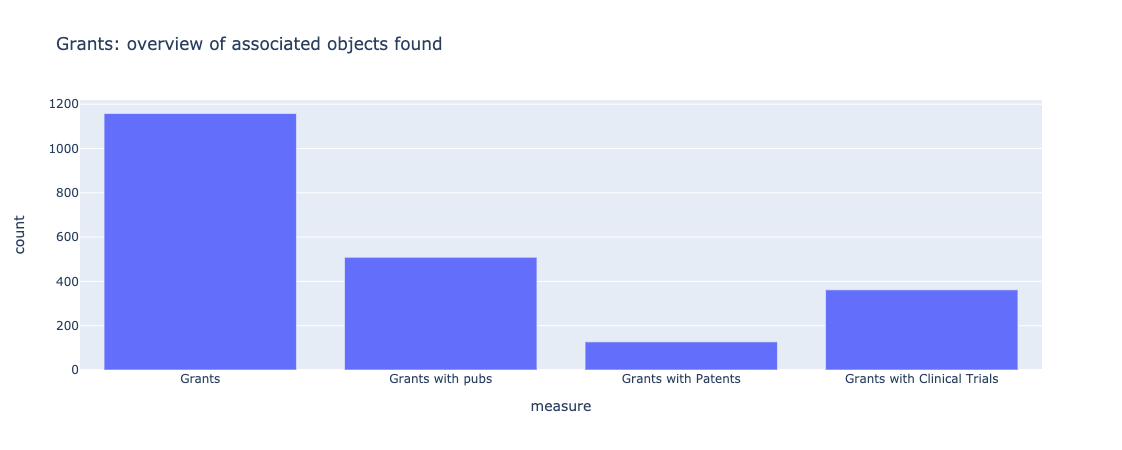

In [92]:
df = pd.DataFrame({
    'measure' : ['Grants', 'Grants with pubs', 'Grants with Patents', 'Grants with Clinical Trials'],
    'count' : [len(grants), len(grants[grants['Resulting Publications'] > 0]), len(grants[grants['Associated Patents'] > 0]), len(grants[grants['Associated Clinical Trials'] > 0])],
})

px.bar(df, 
       x="measure", y="count", 
       title=f"Grants: overview of associated objects found")

### Patents and Clinical Trials by Year

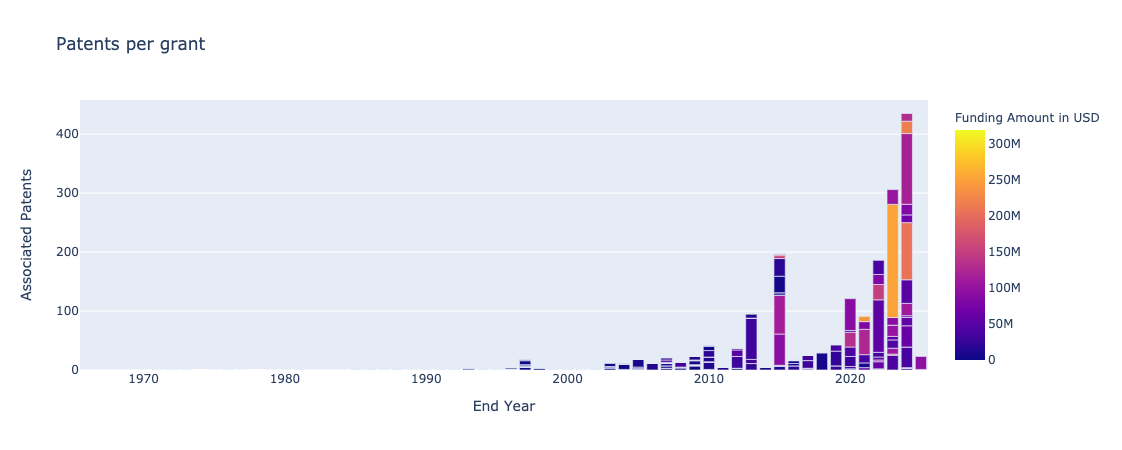

In [93]:
px.bar(grants, 
       x="End Year", y="Associated Patents", 
       color="Funding Amount in USD", 
       hover_name="Title", 
       hover_data=['Dimensions ID', 'Start Year', 'End Year', 'Funder', 'Funder Country'],
       title=f"Patents per grant")

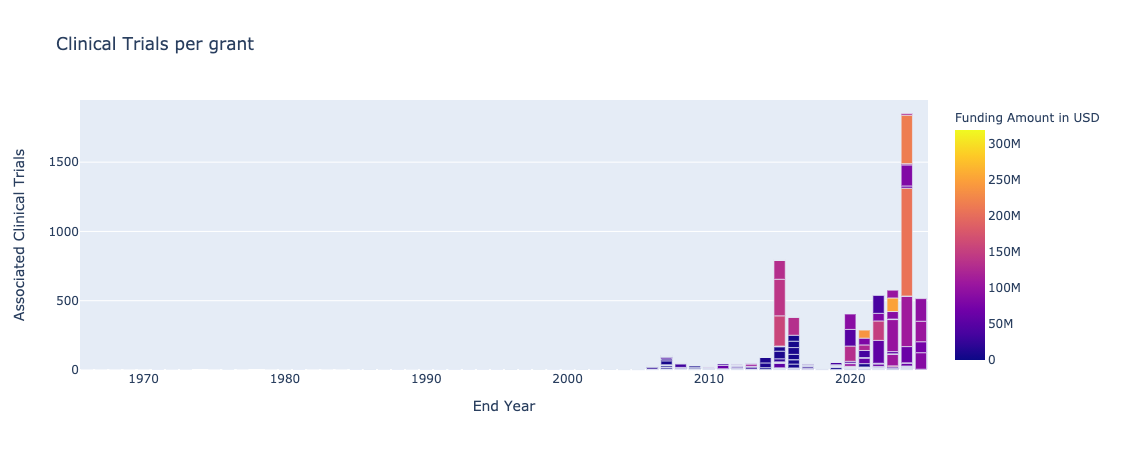

In [94]:
px.bar(grants, 
       x="End Year", y="Associated Clinical Trials", 
       color="Funding Amount in USD", 
       hover_name="Title", 
       hover_data=['Dimensions ID', 'Start Year', 'End Year', 'Funder', 'Funder Country'],
       title=f"Clinical Trials per grant")

### Patents and Clinical Trials by Grant Funder

In [95]:
funders_patents = grants.query('`Associated Patents` > 0')\
    .groupby(['Funder', 'Funder Country'], as_index=False)\
    .sum()\
    .sort_values(by=["Associated Patents"], ascending=False)

funders_trials = grants.query('`Associated Clinical Trials` > 0')\
    .groupby(['Funder', 'Funder Country'], as_index=False)\
    .sum()\
    .sort_values(by=["Associated Clinical Trials"], ascending=False)

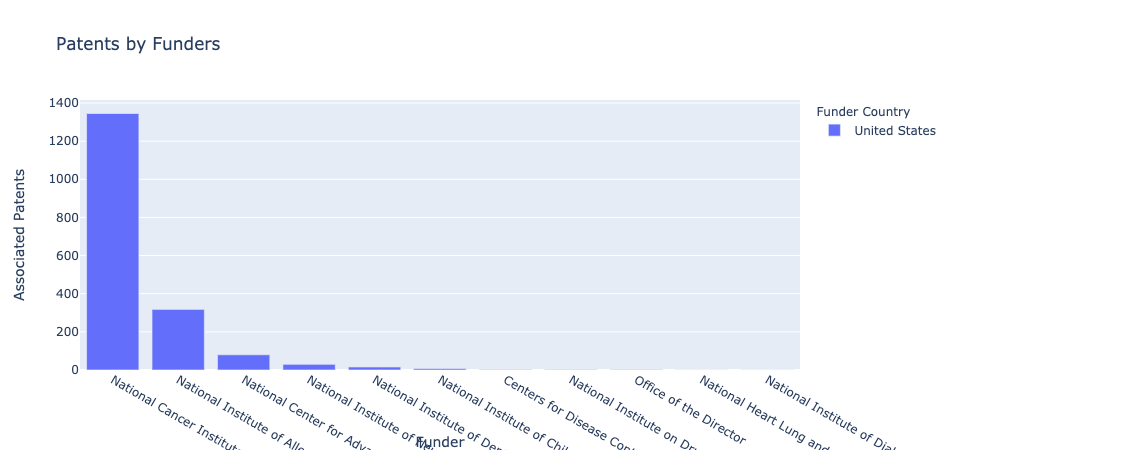

In [96]:
px.bar(funders_patents,  
       y="Associated Patents", x="Funder", 
       color="Funder Country",
       hover_name="Funder", 
       hover_data=['Funder', 'Funder Country'], 
       title=f"Patents by Funders")

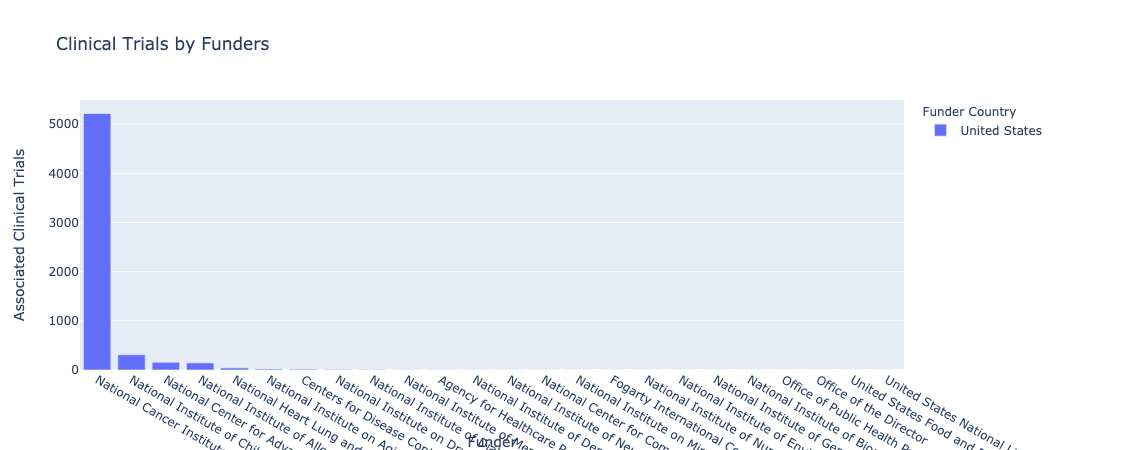

In [97]:
px.bar(funders_trials,  
       y="Associated Clinical Trials", x="Funder", 
       color="Funder Country",
       hover_name="Funder", 
       hover_data=['Funder', 'Funder Country'], 
       title=f"Clinical Trials by Funders")

### Exploring Correlations between dimensions

Tip: a straight diagonal indicates a strong correlation, while a 90 degree angle indicates no correlation. 

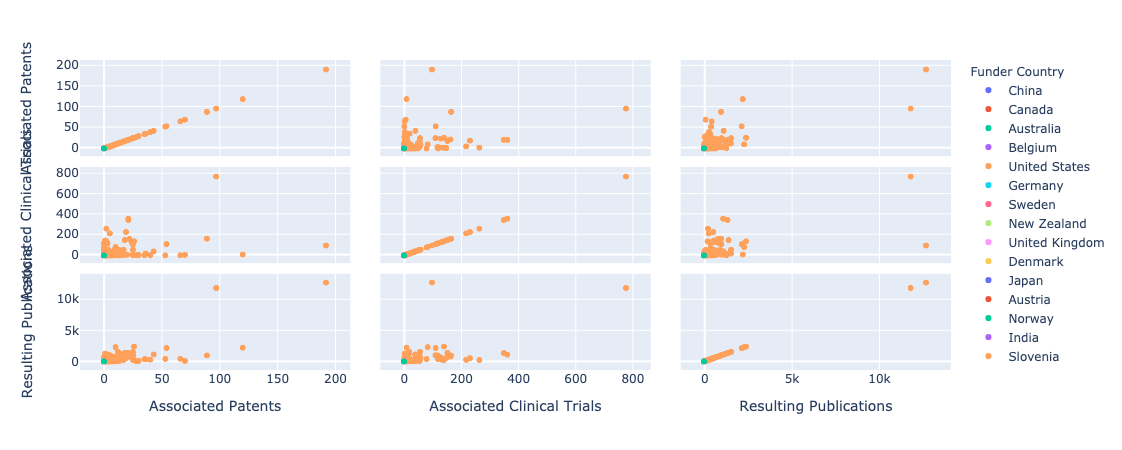

In [98]:
px.scatter_matrix(grants, 
                  dimensions=["Associated Patents", "Associated Clinical Trials", "Resulting Publications"], 
                  color="Funder Country")

--- 

## Conclusion

In this tutorial we have enriched a grants dataset on the topic of 'vaccines' by adding information about patent and clinical trials.
